In [ ]:
!pip install --upgrade --force-reinstall \
  numpy==1.26.4 \
  pandas==2.2.2 \
  scipy==1.11.4 \
  scikit-surprise==1.1.4 \
  gensim==4.3.3 \
  implicit==0.7.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 11.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 7.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 105.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 118.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.8/35.8 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━

In [ ]:
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import coo_matrix
from implicit.als import AlternatingLeastSquares

In [ ]:
from implicit.als import AlternatingLeastSquares

als_model = AlternatingLeastSquares(
    factors=50,
    regularization=0.1,
    iterations=20,
    use_gpu=False   # ⬅️ matikan GPU
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = "/content/drive/My Drive/Colab Notebooks/Word2Vec&ALS/Dataset/amazon.csv"
df = pd.read_csv(DATA_PATH)

print("Shape awal:", df.shape)
print("Kolom:", df.columns.tolist())
print(df.head(3))

# Cek missing value
print("\nMissing values:")
print(df.isnull().sum())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape awal: (1465, 16)
Kolom: ['product_id', 'product_name', 'category', 'discounted_price', 'actual_price', 'discount_percentage', 'rating', 'rating_count', 'about_product', 'user_id', 'user_name', 'review_id', 'review_title', 'review_content', 'img_link', 'product_link']
   product_id                                       product_name  \
0  B07JW9H4J1  Wayona Nylon Braided USB to Lightning Fast Cha...   
1  B098NS6PVG  Ambrane Unbreakable 60W / 3A Fast Charging 1.5...   
2  B096MSW6CT  Sounce Fast Phone Charging Cable & Data Sync U...   

                                            category discounted_price  \
0  Computers&Accessories|Accessories&Peripherals|...             ₹399   
1  Computers&Accessories|Accessories&Peripherals|...             ₹199   
2  Computers&Accessories|Accessories&Peripherals|...             ₹199   

  actual_price discount_percent

In [ ]:
# Pastikan kolom about_product ada
if "about_product" not in df.columns:
    if "product_description" in df.columns:
        df["about_product"] = df["product_description"]
    else:
        df["about_product"] = df["product_name"]

# Bersihkan rating (contoh: "4.0 out of 5" → 4.0)
df["rating"] = df["rating"].astype(str).str.extract(r"(\d+(\.\d+)?)")[0]
df["rating"] = pd.to_numeric(df["rating"], errors="coerce")
df = df.dropna(subset=["about_product","rating"])
df["rating"] = df["rating"].astype(float)

print("Setelah cleaning:", df.shape)


Setelah cleaning: (1464, 16)


/tmp/ipython-input-3039634203.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="rating", data=df, palette="coolwarm")


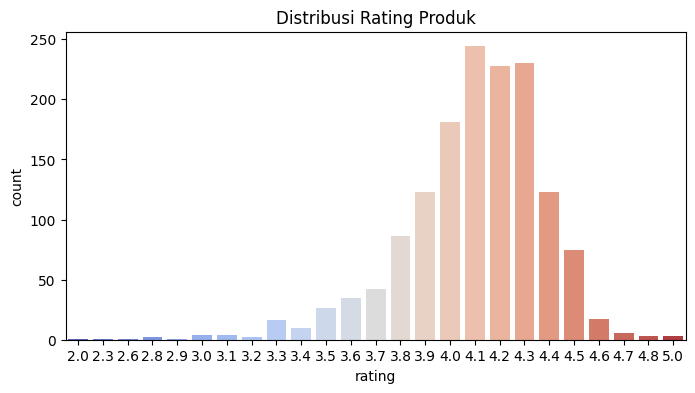

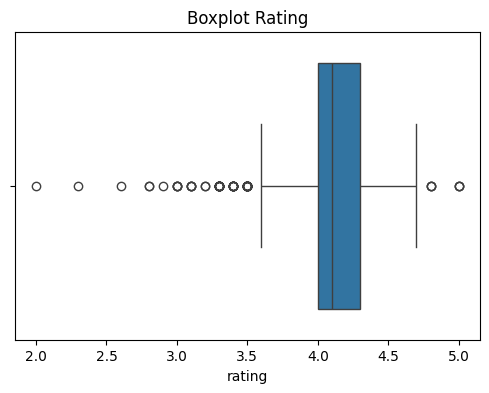

In [ ]:
# Distribusi rating
plt.figure(figsize=(8,4))
sns.countplot(x="rating", data=df, palette="coolwarm")
plt.title("Distribusi Rating Produk")
plt.show()

# Boxplot rating
plt.figure(figsize=(6,4))
sns.boxplot(x=df["rating"])
plt.title("Boxplot Rating")
plt.show()

In [ ]:
def tokenize(text):
    return re.findall(r"\w+", str(text).lower())

df["tokens"] = df["about_product"].apply(tokenize)

# Latih Word2Vec
w2v = Word2Vec(sentences=df["tokens"].tolist(),
               vector_size=100, window=5, min_count=1,
               workers=4, seed=42)

# Buat vektor produk
def get_vector(tokens):
    vecs = [w2v.wv[w] for w in tokens if w in w2v.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(w2v.vector_size)

df["vector"] = df["tokens"].apply(get_vector)
product_matrix = np.vstack(df["vector"].values)

# Fungsi rekomendasi content-based
def cb_recommend(product_name, top_k=5):
    if product_name not in df["product_name"].values:
        return []
    idx = df.index[df["product_name"]==product_name][0]
    sims = cosine_similarity([product_matrix[idx]], product_matrix)[0]
    order = sims.argsort()[::-1]
    order = [i for i in order if i != idx]
    return df.iloc[order[:top_k]][["product_name","rating"]]

# Contoh
sample = df["product_name"].iloc[0]
print("Rekomendasi CB untuk:", sample)
print(cb_recommend(sample, top_k=5))

Rekomendasi CB untuk: Wayona Nylon Braided USB to Lightning Fast Charging and Data Sync Cable Compatible for iPhone 13, 12,11, X, 8, 7, 6, 5, iPad Air, Pro, Mini (3 FT Pack of 1, Grey)
                                          product_name  rating
614  Wayona Nylon Braided USB to Lightning Fast Cha...     4.2
369  Wayona Nylon Braided USB to Lightning Fast Cha...     4.2
220  Wayona Nylon Braided Usb Syncing And Charging ...     4.2
80   Wayona Usb Nylon Braided Data Sync And Chargin...     4.2
430  USB Charger, Oraimo Elite Dual Port 5V/2.4A Wa...     4.0


In [ ]:
# Encode user dan item
df["user_code"] = df["user_id"].astype("category").cat.codes
df["item_code"] = df["product_name"].astype("category").cat.codes

user_map = dict(enumerate(df["user_id"].astype("category").cat.categories))
item_map = dict(enumerate(df["product_name"].astype("category").cat.categories))
reverse_user_map = {v: k for k, v in user_map.items()}

# Matrix user-item
mat = coo_matrix(
    (df["rating"].astype(float), (df["user_code"], df["item_code"]))
)

# Latih model ALS
als = AlternatingLeastSquares(
    factors=50, regularization=0.1, iterations=20, use_gpu=False
)
als.fit(mat.T)

# Fungsi rekomendasi (robust, 1 fungsi saja)
def als_recommend(user_id, top_k=5):
    if user_id not in reverse_user_map:
        return []

    ucode = reverse_user_map[user_id]
    user_items = mat.tocsr()[ucode]

    recs = als.recommend(ucode, user_items, N=top_k)
    results = []

    # === Kasus 1: output tuple (ids, scores)
    if isinstance(recs, tuple) and len(recs) == 2:
        ids, scores = recs
        for i, s in zip(ids, scores):
            results.append((item_map[i], float(s)))

    # === Kasus 2: list of (id, score)
    else:
        for entry in recs:
            try:
                if hasattr(entry, "__len__") and len(entry) >= 2:
                    i, s = entry[0], entry[1]
                    results.append((item_map[i], float(s)))
                else:
                    results.append((item_map[int(entry)], None))
            except Exception:
                results.append((str(entry), None))

    return results

# Contoh rekomendasi
sample_user = df["user_id"].iloc[0]
print("Rekomendasi ALS untuk user:", sample_user)
print(als_recommend(sample_user, top_k=5))

/usr/local/lib/python3.12/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0003249645233154297 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

Rekomendasi ALS untuk user: AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBBSNLYT3ONILA,AHCTC6ULH4XB6YHDY6PCH2R772LQ,AGYHHIERNXKA6P5T7CZLXKVPT7IQ,AG4OGOFWXJZTQ2HKYIOCOY3KXF2Q,AENGU523SXMOS7JPDTW52PNNVWGQ,AEQJHCVTNINBS4FKTBGQRQTGTE5Q,AFC3FFC5PKFF5PMA52S3VCHOZ5FQ
[('Acer 80 cm (32 inches) N Series HD Ready TV AR32NSV53HD (Black)', 0.10976743698120117), ('Spigen Ultra Hybrid Back Cover Case Compatible with iPhone 14 Pro max (TPU + Poly Carbonate | Crystal Clear)', 0.10725060105323792), ('Havells Instanio 3-Litre 4.5KW Instant Water Heater (Geyser), White Blue', 0.08819983899593353), ('MYVN LTG to USB for\xa0Fast Charging & Data Sync USB Cable Compatible for iPhone 5/5s/6/6S/7/7+/8/8+/10/11, iPad Air/Mini, iPod and iOS Devices (1 M)', 0.08510880917310715), ('Duracell Micro USB 3A Braided Sync & Fast Charging Cable, 3.9 Feet (1.2M). Supports QC 2.0/3.0 Charging, High Speed Data Transmission - Black', 0.07240801304578781)]


Top-5 produk:
 product_name
Amazon Basics Wireless Mouse | 2.4 GHz Connection, 1600 DPI | Type - C Adapter | Upto 12 Months of Battery Life | Ambidextrous Design | Suitable for PC/Mac/Laptop                               5.0
Syncwire LTG to USB Cable for Fast Charging Compatible with Phone 5/ 5C/ 5S/ 6/ 6S/ 7/8/ X/XR/XS Max/ 11/12/ 13 Series and Pad Air/Mini, Pod & Other Devices (1.1 Meter, White)                  5.0
REDTECH USB-C to Lightning Cable 3.3FT, [Apple MFi Certified] Lightning to Type C Fast Charging Cord Compatible with iPhone 14/13/13 pro/Max/12/11/X/XS/XR/8, Supports Power Delivery - White    5.0
Instant Pot Air Fryer, Vortex 2QT, Touch Control Panel, 360° EvenCrisp™ Technology, Uses 95 % less Oil, 4-in-1 Appliance: Air Fry, Roast, Bake, Reheat (Vortex 1.97Litre, Black)                 4.8
Swiffer Instant Electric Water Heater Faucet Tap Home-Kitchen Instantaneous Water Heater Tank less for Tap, LED Electric Head Water Heaters Tail Gallon Comfort(3000W) ((Pack of 1))    

/tmp/ipython-input-808606388.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top5.index, y=top5.values, palette="Greens_r")


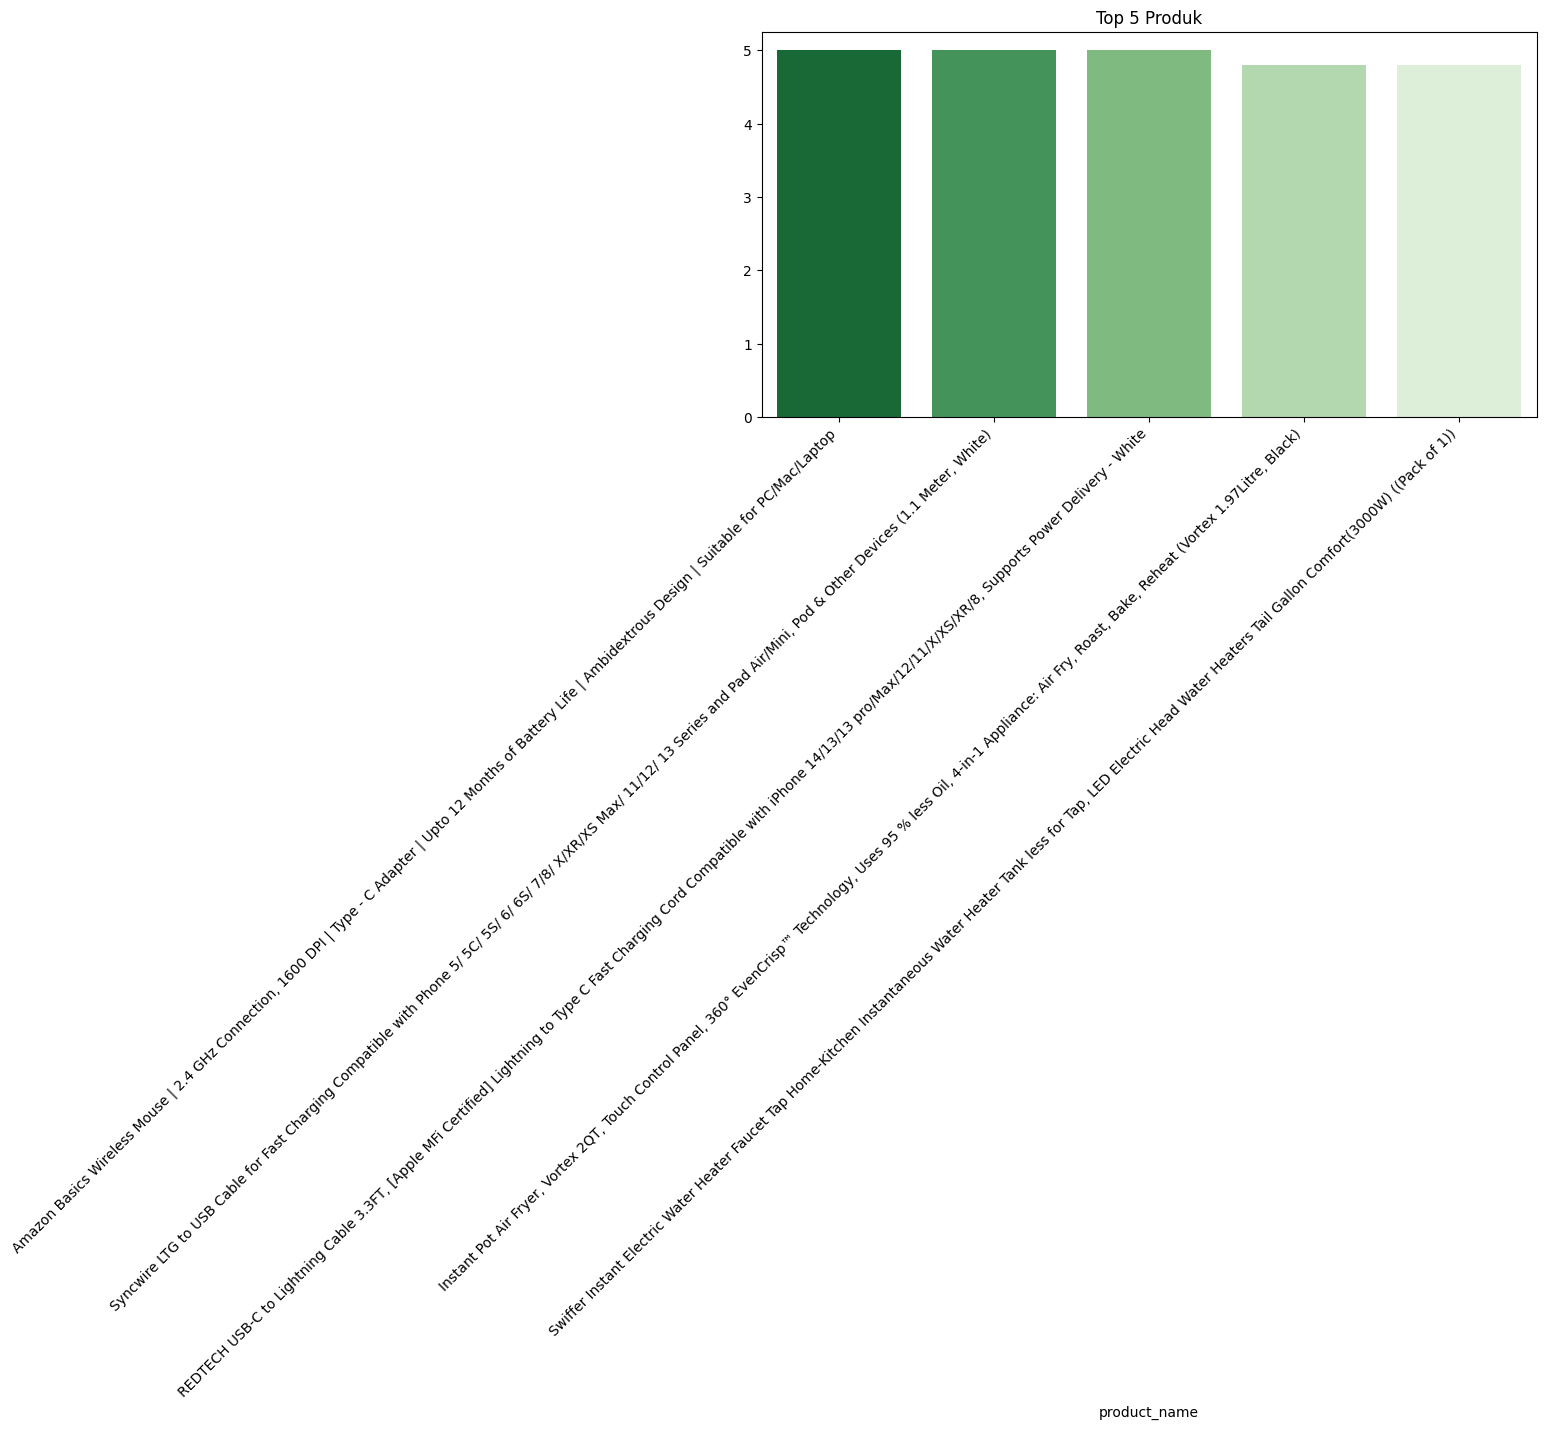

In [ ]:
top5 = df.groupby("product_name")["rating"].mean().sort_values(ascending=False).head(5)
low5 = df.groupby("product_name")["rating"].mean().sort_values(ascending=True).head(5)

print("Top-5 produk:\n", top5)
print("Bottom-5 produk:\n", low5)

plt.figure(figsize=(10,5))
sns.barplot(x=top5.index, y=top5.values, palette="Greens_r")
plt.title("Top 5 Produk")
plt.xticks(rotation=45, ha="right")
plt.show()